### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_add_inference_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        mask_type = self.df["mask_type"][idx]
        from_inference = self.df["inference"][idx]
        inference_from_which_dataset = self.df["from_folder"][idx]
        
        if dataset == "ge":
            from_dataset = 1
        elif dataset == "benq":
            from_dataset = 2

        if mask_type == "nodule":
            mask_type = 1
        elif mask_type == "gland":
            mask_type = 2

        if from_inference == False:
            if dataset == "benq":
                from_folder = "../gland_data"
            elif dataset == "ge":
                if mask_type == 1:
                    from_folder = "../ge_data/nodule"
                else:
                    from_folder = "../ge_data/gland"
            
            image_path = f"{from_folder}/images/{image_name}"
            mask_path = f"{from_folder}/masks/{mask_name}"
        else:
            if inference_from_which_dataset == "ge_gland":
                image_path = f"../ge_data/gland/images/{image_name}"
                mask_path = f"../ge_data/gland/from_scratch_inference_masks_all_v1/nodule/{mask_name}"
            else:
                print("not find!!")

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset, mask_type

In [5]:
image_size = 128
batch_size = 256
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_train_add_inference_v1.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_add_inference_Dataset("../ge_benq_data/ge(nodule_gland)_benq(gland)_test_add_inference_v1.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset, mask_type = next(iter(test_dataloader))

KeyError: 'from_folder'

In [8]:
train_dataset.df["from_folder"][0]

nan

In [7]:
mask_type

tensor([1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1,
        1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2,
        2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2])

In [8]:
print(len(train_dataset), len(test_dataset))

788 218


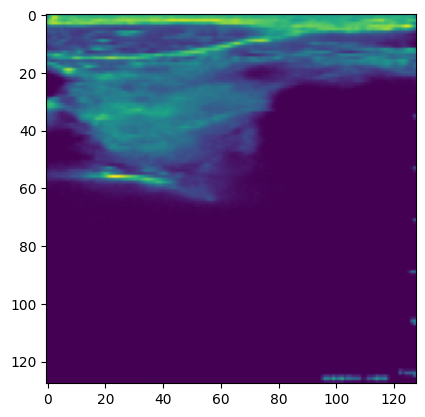

In [9]:
plt.imshow(image[18][0])

In [10]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue

        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0

    total_ge_nodule_IOU = 0
    total_ge_gland_IOU = 0
    total_benq_gland_IOU = 0
    
    total_ge_nodule_DICE = 0
    total_ge_gland_DICE = 0
    total_benq_gland_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, from_dataset, mask_type in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        # get output
        ge_nodule_output = nodule_output[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_output = gland_output[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_output = gland_output[(from_dataset == 2) & (mask_type == 2)]

        # get len
        ge_nodule_len = ge_nodule_output.shape[0]
        ge_gland_len = ge_gland_output.shape[0]
        benq_gland_len = benq_gland_output.shape[0]

        if ge_nodule_len == 0 or ge_gland_len == 0 or benq_gland_len == 0:
            continue
        nodule_ratio = ge_nodule_len / (ge_nodule_len + ge_gland_len + benq_gland_len)
        gland_ratio = (ge_gland_len + benq_gland_len) / (ge_nodule_len + ge_gland_len + benq_gland_len)
        
        ge_gland_ratio = ge_gland_len / (ge_gland_len + benq_gland_len)
        benq_gland_ratio = benq_gland_len / (ge_gland_len + benq_gland_len)
        
        # get mask
        ge_nodule_mask = mask[(from_dataset == 1) & (mask_type == 1)]
        ge_gland_mask = mask[(from_dataset == 1) & (mask_type == 2)]
        benq_gland_mask = mask[(from_dataset == 2) & (mask_type == 2)]
        
        #get loss
        ge_nodule_loss = loss_fn(ge_nodule_output, ge_nodule_mask)
        ge_gland_loss = loss_fn(ge_gland_output, ge_gland_mask)
        benq_gland_loss = loss_fn(benq_gland_output, benq_gland_mask)

        nodule_loss = ge_nodule_loss
        gland_loss = (ge_gland_loss * ge_gland_ratio + benq_gland_loss * benq_gland_ratio)
        loss = (nodule_loss * nodule_ratio + gland_loss * gland_ratio)
        
        # get IOU
        ge_nodule_IOU = IOU_score(ge_nodule_output, ge_nodule_mask)
        ge_gland_IOU = IOU_score(ge_gland_output, ge_gland_mask)
        benq_gland_IOU = IOU_score(benq_gland_output, benq_gland_mask)

        nodule_IOU = ge_nodule_IOU
        gland_IOU = (ge_gland_IOU * ge_gland_ratio + benq_gland_IOU * benq_gland_ratio)
        IOU = (nodule_IOU * nodule_ratio + gland_IOU * gland_ratio)

        # get DICE
        dice_loss = DiceLoss()
        
        ge_nodule_DICE = 1 - dice_loss(ge_nodule_output, ge_nodule_mask)
        ge_gland_DICE = 1 - dice_loss(ge_gland_output, ge_gland_mask)
        benq_gland_DICE = 1 - dice_loss(benq_gland_output, benq_gland_mask)

        nodule_DICE = ge_nodule_DICE
        gland_DICE = (ge_gland_DICE * ge_gland_ratio + benq_gland_DICE * benq_gland_ratio)
        DICE = (nodule_DICE * nodule_ratio + gland_DICE * gland_ratio)

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        total_ge_nodule_IOU += ge_nodule_IOU
        total_ge_gland_IOU += ge_gland_IOU
        total_benq_gland_IOU += benq_gland_IOU

        total_ge_nodule_DICE += ge_nodule_DICE
        total_ge_gland_DICE += ge_gland_DICE
        total_benq_gland_DICE += benq_gland_DICE
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, total_ge_nodule_IOU/count, total_ge_gland_IOU/count, total_benq_gland_IOU/count, total_ge_nodule_DICE/count, total_ge_gland_DICE/count, total_benq_gland_DICE/count

    

In [11]:

# inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [12]:
# # freeze encoder
# for param in model.backbone.parameters():
#     param.requires_grad = False

In [13]:

epochs = 500
lr = 0.01
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:

project = "thyroid_ge_benq_finetune"
name = "hybrid_model_ge(nodule_gland)_benq(gland)_from_scratch_v1"
# name = "test"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [16]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_nodule_IOU_train, ge_gland_IOU_train, benq_gland_IOU_train, ge_nodule_DICE_train, ge_gland_DICE_train, benq_gland_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_nodule_IOU_val, ge_gland_IOU_val, benq_gland_IOU_val, ge_nodule_DICE_val, ge_gland_DICE_val, benq_gland_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/ge_benq/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/ge_benq/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_nodule_IOU" : ge_nodule_IOU_train,
        "train_ge_nodule_DICE" : ge_nodule_DICE_train,
        "train_ge_gland_IOU" : ge_gland_IOU_train,
        "train_ge_gland_DICE" : ge_gland_DICE_train,
        "train_benq_gland_IOU" : benq_gland_IOU_train,
        "train_benq_gland_DICE" : benq_gland_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_nodule_IOU" : ge_nodule_IOU_val,
        "val_ge_nodule_DICE" : ge_nodule_DICE_val,
        "val_ge_gland_IOU" : ge_gland_IOU_val,
        "val_ge_gland_DICE" : ge_gland_DICE_val,
        "val_benq_gland_IOU" : benq_gland_IOU_val,
        "val_benq_gland_DICE" : benq_gland_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/ge_benq/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


train loss : 1.1061830009732927, train IOU : 0.19246906294886554, train DICE : 0.24166934617928096


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.9255535900592804, val IOU : 0.38798287510871887, val DICE : 0.40310001373291016
epoch : 1


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.7573035359382629, train IOU : 0.42122564145496916, train DICE : 0.4940377814429147


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.9428499341011047, val IOU : 0.4147159457206726, val DICE : 0.5093801021575928
epoch : 2


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.6381292683737618, train IOU : 0.4775890793119158, train DICE : 0.5885524834905352


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.8061575591564178, val IOU : 0.47990214824676514, val DICE : 0.5796007513999939
epoch : 3


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.5791084269682566, train IOU : 0.5208430290222168, train DICE : 0.644088864326477


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.8020357489585876, val IOU : 0.46376438438892365, val DICE : 0.5782224535942078
epoch : 4


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.5113373909677777, train IOU : 0.5684030396597726, train DICE : 0.6959765638623919


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.8418375849723816, val IOU : 0.4677165150642395, val DICE : 0.5879263579845428
epoch : 5


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.4579337750162397, train IOU : 0.6122110741479057, train DICE : 0.7392337577683585


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.8095763027667999, val IOU : 0.47786006331443787, val DICE : 0.5991316437721252
epoch : 6


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.44711398226874216, train IOU : 0.6177494951656887, train DICE : 0.7465190546853202


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.9390868246555328, val IOU : 0.4613102078437805, val DICE : 0.5574427247047424
epoch : 7


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


train loss : 0.4347602476676305, train IOU : 0.6297760903835297, train DICE : 0.755761593580246


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.9063688218593597, val IOU : 0.472848579287529, val DICE : 0.5836342573165894
epoch : 8


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


train loss : 0.3984314927033016, train IOU : 0.6700297168322972, train DICE : 0.7817007218088422


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.8338223695755005, val IOU : 0.4809764623641968, val DICE : 0.589195042848587
epoch : 9


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.3633263622011457, train IOU : 0.6896085824285235, train DICE : 0.8057111161095756


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.8887215554714203, val IOU : 0.503896951675415, val DICE : 0.6052461862564087
epoch : 10


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


train loss : 0.34694591590336393, train IOU : 0.7125659499849591, train DICE : 0.823062104838235


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.848704606294632, val IOU : 0.5102716386318207, val DICE : 0.6240949928760529
epoch : 11


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


train loss : 0.32394376397132874, train IOU : 0.7313402806009565, train DICE : 0.8328279001372201


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.9698421657085419, val IOU : 0.4683443009853363, val DICE : 0.5889927446842194
epoch : 12


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.294048262493951, train IOU : 0.7605230978557042, train DICE : 0.8550675596509661


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 1.0059276819229126, val IOU : 0.49093079566955566, val DICE : 0.6137703359127045
epoch : 13


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


train loss : 0.2951168765624364, train IOU : 0.7527189751466116, train DICE : 0.8544906874497732


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.8305252492427826, val IOU : 0.5492863357067108, val DICE : 0.6630208790302277
epoch : 14


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


train loss : 0.26938155932085855, train IOU : 0.7787066527775356, train DICE : 0.869528089250837


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.7452090680599213, val IOU : 0.5537046194076538, val DICE : 0.6606141924858093
epoch : 15


100%|██████████| 7/7 [00:09<00:00,  1.43s/it]


train loss : 0.26899652431408566, train IOU : 0.7774145503838857, train DICE : 0.8669251104195913


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.8766781389713287, val IOU : 0.5436825454235077, val DICE : 0.6625569462776184
epoch : 16


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.24545625490801676, train IOU : 0.7984668612480164, train DICE : 0.8823549236570086


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 1.0329569280147552, val IOU : 0.5315855443477631, val DICE : 0.6488494277000427
epoch : 17


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.23573164216109685, train IOU : 0.8075127942221505, train DICE : 0.8885969945362636


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.8961763978004456, val IOU : 0.5394467413425446, val DICE : 0.6628913581371307
epoch : 18


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


train loss : 0.22067779302597046, train IOU : 0.8224584204810006, train DICE : 0.8976265447480338


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.9705576300621033, val IOU : 0.5303567945957184, val DICE : 0.6442880034446716
epoch : 19


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


train loss : 0.21988009554999216, train IOU : 0.8099653806005206, train DICE : 0.8923313702855792


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.8709600865840912, val IOU : 0.5545057654380798, val DICE : 0.6730036735534668
epoch : 20


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


train loss : 0.22959029035908834, train IOU : 0.8111192498888288, train DICE : 0.8926895260810852


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.9114182591438293, val IOU : 0.5555715560913086, val DICE : 0.6728264689445496
epoch : 21


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.21956267527171544, train IOU : 0.8177574106625148, train DICE : 0.8962201646396092


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 1.0649994611740112, val IOU : 0.5301568806171417, val DICE : 0.6353787183761597
epoch : 22


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


train loss : 0.23059957580907003, train IOU : 0.8110780715942383, train DICE : 0.8880017059189933


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.9866710901260376, val IOU : 0.551599383354187, val DICE : 0.6721323728561401
epoch : 23


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.21954494288989476, train IOU : 0.8118803926876613, train DICE : 0.8901047110557556


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


val loss : 0.9019665718078613, val IOU : 0.5734015703201294, val DICE : 0.6889221966266632
epoch : 24


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


train loss : 0.238131759422166, train IOU : 0.7985048804964338, train DICE : 0.8816306931631905


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.9592742025852203, val IOU : 0.5524670481681824, val DICE : 0.6712495684623718
epoch : 25


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.2221620104142598, train IOU : 0.8225376861436027, train DICE : 0.896838366985321


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.8160344958305359, val IOU : 0.5758456587791443, val DICE : 0.6979488134384155
epoch : 26


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.23125619334833963, train IOU : 0.8078126396451678, train DICE : 0.8896996378898621


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.9492957592010498, val IOU : 0.5563908219337463, val DICE : 0.6707368791103363
epoch : 27


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.20622759560743967, train IOU : 0.8303290704886118, train DICE : 0.904049297173818


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


val loss : 0.8548884689807892, val IOU : 0.5808506011962891, val DICE : 0.6948679983615875
epoch : 28


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.18958917756875357, train IOU : 0.8416121105353037, train DICE : 0.9118075966835022


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


val loss : 0.9191184639930725, val IOU : 0.5769429206848145, val DICE : 0.6943793296813965
epoch : 29


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.17489390713827951, train IOU : 0.8520147459847587, train DICE : 0.9194856200899396


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.9760603606700897, val IOU : 0.5901541411876678, val DICE : 0.7117370069026947
epoch : 30


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


train loss : 0.1746991624434789, train IOU : 0.8544871310393015, train DICE : 0.9207113782564799


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 1.0846911668777466, val IOU : 0.5729640424251556, val DICE : 0.6935537457466125
epoch : 31


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


train loss : 0.16344283946922847, train IOU : 0.8651882239750454, train DICE : 0.9261875833783831


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 1.1691128611564636, val IOU : 0.562908262014389, val DICE : 0.6797201037406921
epoch : 32


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


train loss : 0.16063162684440613, train IOU : 0.8663386404514313, train DICE : 0.928622325261434


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 1.037543386220932, val IOU : 0.5726715922355652, val DICE : 0.6996799111366272
epoch : 33


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.15514490646975382, train IOU : 0.8718187212944031, train DICE : 0.9302283270018441


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 0.9209968447685242, val IOU : 0.5980736613273621, val DICE : 0.7177795767784119
epoch : 34


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


train loss : 0.1518387006861823, train IOU : 0.8741776176861354, train DICE : 0.931483805179596


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 1.2388795018196106, val IOU : 0.562322348356247, val DICE : 0.6828156411647797
epoch : 35


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


train loss : 0.15175339579582214, train IOU : 0.8720454829079765, train DICE : 0.9311391881534031


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 1.1343151330947876, val IOU : 0.580658495426178, val DICE : 0.701179563999176
epoch : 36


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


train loss : 0.15901157472814834, train IOU : 0.8633274521146502, train DICE : 0.9276055949074882


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 1.0817716717720032, val IOU : 0.5863194167613983, val DICE : 0.7090869843959808
epoch : 37


100%|██████████| 7/7 [00:09<00:00,  1.43s/it]


train loss : 0.17360338355813706, train IOU : 0.8545251148087638, train DICE : 0.9231544477599007


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.8525267243385315, val IOU : 0.5995767414569855, val DICE : 0.7200961112976074
epoch : 38


100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


train loss : 0.16792331423078263, train IOU : 0.8622207641601562, train DICE : 0.9256296583584377


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


val loss : 0.9439628720283508, val IOU : 0.5768761336803436, val DICE : 0.6953763067722321
epoch : 39


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


train loss : 0.16143366694450378, train IOU : 0.8668426672617594, train DICE : 0.9288857479890188


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


val loss : 0.9437248706817627, val IOU : 0.5997393727302551, val DICE : 0.7269632816314697
epoch : 40


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.1521209946700505, train IOU : 0.8752283368791852, train DICE : 0.9327977129391262


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


val loss : 0.9537404179573059, val IOU : 0.6036620438098907, val DICE : 0.7258768975734711
epoch : 41


100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


train loss : 0.14659434769834792, train IOU : 0.8725533826010567, train DICE : 0.9335985950061253


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


val loss : 1.440877079963684, val IOU : 0.533738374710083, val DICE : 0.6513237953186035
epoch : 42


 71%|███████▏  | 5/7 [00:09<00:03,  1.83s/it]


KeyboardInterrupt: 